# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)

Read the "introduction to pytorch" 
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss (use ```torch.nn.MSELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.

### Dataset A

size of x_data: torch.Size([100, 1])
size of y_data: torch.Size([100, 1])


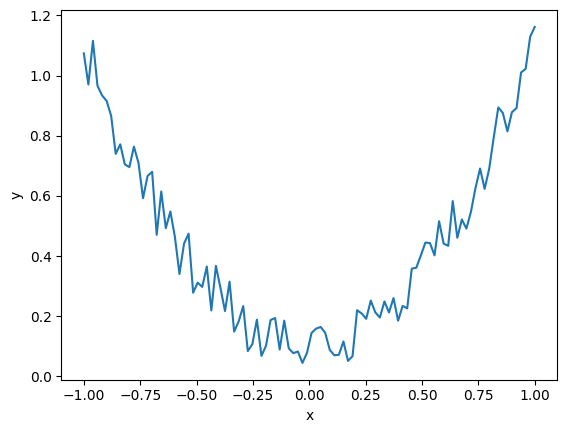

In [ ]:
m = 100

x_data = torch.linspace(-1, 1, m)
noise_data = 0.2*torch.rand(m)
y_data = x_data.pow(2) + noise_data

# --- change vectos to matrix
x_data = torch.unsqueeze(x_data, dim=1)
y_data = torch.unsqueeze(y_data, dim=1)

# ----------------
plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Dataset B

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


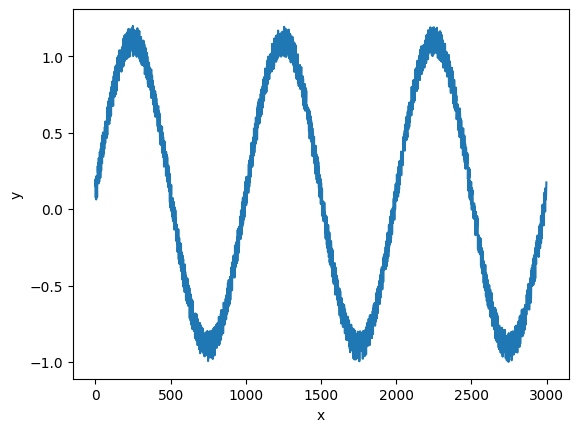

In [ ]:
m = 3000

x_data = torch.arange(0, m, dtype=torch.float32)
noise_data = 0.2*torch.rand(m)
y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

# --- change vectos to matrix
x_data = torch.unsqueeze(x_data, dim=1)
y_data = torch.unsqueeze(y_data, dim=1)

# ----------------
plt.plot(x_data.numpy(),y_data.numpy())
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [ ]:
# --- START CODE HERE
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
# --- END CODE HERE

## Definition of the hyper-parameters

In [ ]:
n_in = 1
n_h = 10
n_out = 1

nbEpoch = 20000
alpha = 0.05

## Model 1 (writting the network equations)

For model 1, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable. 
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/nn.html#linear for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [ ]:
# --- START CODE HERE
W1 = torch.randn((n_in, n_h), requires_grad=True)
b1 = torch.zeros(n_h, requires_grad=True)
W2 = torch.randn((n_h, n_out), requires_grad=True)
b2 = torch.zeros(n_out, requires_grad=True)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [ ]:
def model(X):
    
    # --- H is the results of the first projection
    # --- H is then transformed by a non-linearity to A
    
    # --- START CODE HERE
    H = X @ W1  + b1
    A = nn.ReLU()(H)
    hat_y = A @ W2 + b2
    # --- END CODE HERE
    return hat_y

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [ ]:
for epoch in range(0, nbEpoch):    
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    hat_y = model(x_data)
    loss = ((hat_y - y_data) ** 2).mean()
    # --- END CODE HERE
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    loss.backward()
    
    with torch.no_grad():
        # --- START CODE HERE
        W1 -= alpha*W1.grad
        b1 -= alpha*b1.grad
        W2 -= alpha*W2.grad
        b2 -= alpha*b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        

epoch 0, loss 0.050032839179039
epoch 1000, loss 0.03440704569220543
epoch 2000, loss 0.0343911275267601
epoch 3000, loss 0.03438075631856918
epoch 4000, loss 0.03437068313360214
epoch 5000, loss 0.03435903042554855
epoch 6000, loss 0.03434373810887337
epoch 7000, loss 0.03432265669107437
epoch 8000, loss 0.03429311886429787
epoch 9000, loss 0.034252725541591644
epoch 10000, loss 0.034200217574834824
epoch 11000, loss 0.0341368243098259
epoch 12000, loss 0.03406711295247078
epoch 13000, loss 0.033993199467659
epoch 14000, loss 0.03392579406499863
epoch 15000, loss 0.03378525376319885
epoch 16000, loss 0.033696744590997696
epoch 17000, loss 0.033642809838056564
epoch 18000, loss 0.03361906856298447
epoch 19000, loss 0.03360762819647789


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

ValueError: ignored

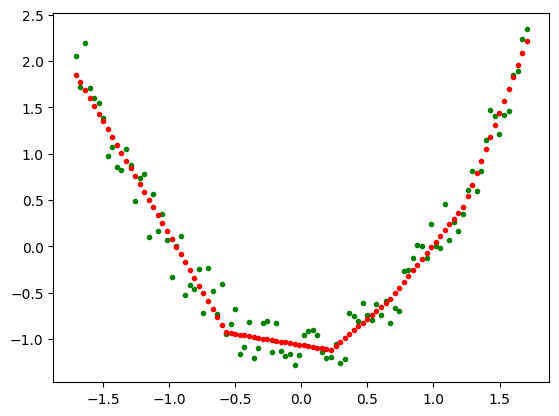

In [ ]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), hat_y.detach().numpy(), 'r.');
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), 1, 'b+');

In [ ]:
# --- START CODE HERE
model2 = nn.Sequential(
    nn.Linear(n_in, n_h),
    nn.ReLU(),
    nn.Linear(n_h, n_out)
)
# --- END CODE HERE

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # --- START CODE HERE
        self.hidden = nn.Linear(n_in, n_h)
        self.predict = nn.Linear(n_h, n_out)
        # --- END CODE HERE
        
    def forward(self, x):
        
        # --- START CODE HERE
        h = self.hidden(x)
        h = nn.ReLU()(h)
        hat_y = self.predict(h)
        # --- END CODE HERE
        
        return hat_y

# --- START CODE HERE
model3 = Net()
# --- END CODE HERE

## Criterion and Optimization for model 2 and model 3

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forawrd, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [ ]:
# --- START CODE HERE
criterion = nn.MSELoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=alpha)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=alpha)
# --- END CODE HERE

## Training for model 2 and 3

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

epoch 0, loss 0.9044914245605469
epoch 1000, loss 0.04226292297244072
epoch 2000, loss 0.03925454244017601
epoch 3000, loss 0.0390264168381691
epoch 4000, loss 0.03899338096380234
epoch 5000, loss 0.0389847531914711
epoch 6000, loss 0.038982659578323364
epoch 7000, loss 0.038982175290584564
epoch 8000, loss 0.03898203745484352
epoch 9000, loss 0.03898201510310173
epoch 10000, loss 0.03898201510310173
epoch 11000, loss 0.03898201137781143
epoch 12000, loss 0.03898199647665024
epoch 13000, loss 0.038982000201940536
epoch 14000, loss 0.03898201510310173
epoch 15000, loss 0.03898198530077934
epoch 16000, loss 0.038982003927230835
epoch 17000, loss 0.03898200765252113
epoch 18000, loss 0.038982000201940536
epoch 19000, loss 0.03898198902606964


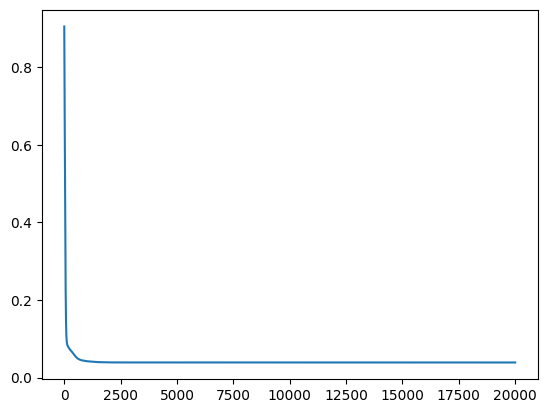

In [ ]:
loss_l = []
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    optimizer2.zero_grad()
    pred_y = model2(x_data)
    loss = criterion(pred_y, y_data)
    loss_l.append(loss.item())
    loss.backward()
    optimizer2.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))
        
# ----------------
plt.plot(loss_l)

epoch 0, loss 1.105401873588562
epoch 1000, loss 0.03952869400382042
epoch 2000, loss 0.034100569784641266
epoch 3000, loss 0.032277002930641174
epoch 4000, loss 0.03197629749774933
epoch 5000, loss 0.03190110623836517
epoch 6000, loss 0.03187137469649315
epoch 7000, loss 0.031856611371040344
epoch 8000, loss 0.03184673190116882
epoch 9000, loss 0.03183916583657265
epoch 10000, loss 0.03183308243751526
epoch 11000, loss 0.03182828798890114
epoch 12000, loss 0.03182446211576462
epoch 13000, loss 0.03182131424546242
epoch 14000, loss 0.031818829476833344
epoch 15000, loss 0.0318169929087162
epoch 16000, loss 0.031815413385629654
epoch 17000, loss 0.03181428462266922
epoch 18000, loss 0.03181328997015953
epoch 19000, loss 0.03181250020861626


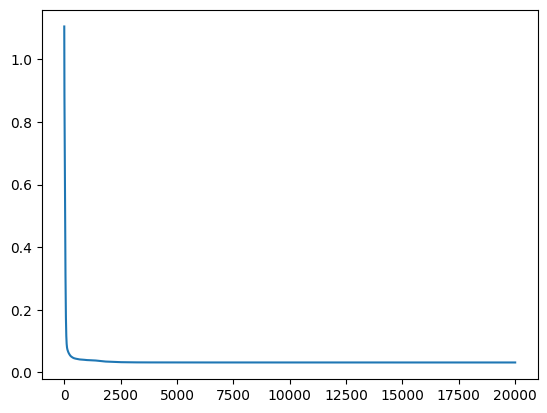

In [ ]:
loss_l = []
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    optimizer3.zero_grad()
    pred_y = model3(x_data)
    loss = criterion(pred_y, y_data)
    loss_l.append(loss.item())
    loss.backward()
    optimizer3.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))
        
# ----------------
plt.plot(loss_l)

## Plotting results

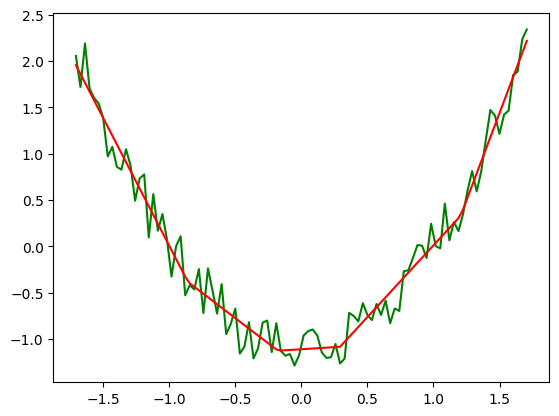

In [ ]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), pred_y.detach().numpy(), 'r')

## Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

In [ ]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())